Robot Movement using (UCS):


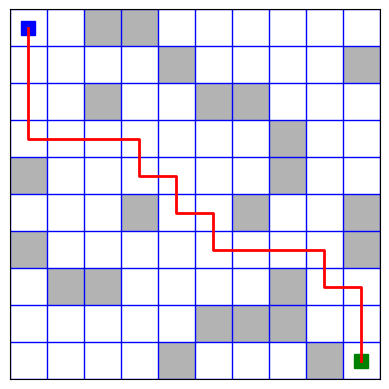

Total Count of recharges (UCS): 6
Total Moves (UCS): 60
Final Battery Percentage (UCS): 100


Robot Movement using (A*):


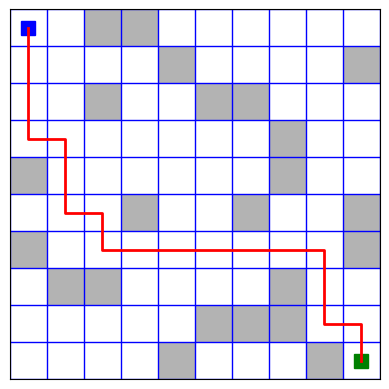

Total Count of recharges (A*): 4
Total Moves (A*): 46
Final Battery Percentage (A*): 40


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

    def top(self):
        return self.elements[0][1]


class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost


    def __lt__(self, other):
        return self.path_cost < other.path_cost

def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.initial = start
        self.goal = goal

    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions


    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)


    def is_goal(self, state):
        return state == self.goal

class Robot:
    def __init__(self, env):
        self.env = env

    def recharge_battery(self):
        return 100

    def ucs_search(self):
        battery_level = 100
        recharge_count = 0
        move_count = 0
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                solution_path = self.reconstruct_path(came_from, current_node.state)
                return solution_path, recharge_count, move_count, battery_level
            move_count+=1
            battery_level-=10
            if battery_level <= 0:
               battery_level = self.recharge_battery()
               recharge_count += 1

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    frontier.put(Node(new_state, current_node, action, new_cost), new_cost)
                    came_from[new_state] = current_node.state


        return [], recharge_count, move_count, battery_level

    def a_star_search(self):
        battery_level = 100
        recharge_count = 0
        move_count = 0
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}


        while not frontier.empty():
            current_node = frontier.get()


            if self.env.is_goal(current_node.state):
                solution_path = self.reconstruct_path(came_from, current_node.state)
                return solution_path, recharge_count, move_count, battery_level
            battery_level -= 10
            move_count += 1
            if  battery_level <= 0:
                    battery_level = self.recharge_battery()
                    recharge_count += 1

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)
                    frontier.put(Node(new_state, current_node, action, new_cost), priority)
                    came_from[new_state] = current_node.state


        return [], recharge_count, move_count, battery_level

    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.initial)
        path.reverse()
        return path

def visualize_grid_and_path(grid, path):
    grid_array = np.array(grid)
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0.3)
    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'bs', markersize=10)
    ax.plot(goal[1], goal[0], 'gs', markersize=10)
    xs, ys = zip(*path)
    ax.plot(ys, xs, 'r-', linewidth=2)
    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()


def generate_random_grid(size, obstacle_probability):
    return np.random.choice([0, 1], size=(size, size), p=[1-obstacle_probability, obstacle_probability])


grid_size = 10
obstacle_probability = 0.2


grid = generate_random_grid(grid_size, obstacle_probability)


start = (0, 0)
goal = (grid_size - 1, grid_size - 1)


grid[start] = 0
grid[goal] = 0


environment = Environment(grid, start, goal)
agent = Robot(environment)

solution_path_ucs,recharge_count,move_count, final_battery_ucs = agent.ucs_search()
print("Robot Movement using (UCS):")
visualize_grid_and_path(grid, solution_path_ucs)
print("Total Count of recharges (UCS):", recharge_count)
print("Total Moves (UCS):", move_count)
print("Final Battery Percentage (UCS):", final_battery_ucs)
print("\n")
solution_path,recharge_count1,move_count1,final_battery_astar = agent.a_star_search()
print("Robot Movement using (A*):")
visualize_grid_and_path(grid, solution_path)
print("Total Count of recharges (A*):", recharge_count1)
print("Total Moves (A*):", move_count1)
print("Final Battery Percentage (A*):", final_battery_astar)